In [25]:
# Any number of GCN and LSTM layers can be added
# Dropout and dense layers decrease the over-fitting problem
# TODO: What can we change?
# Method here is used for univariate (single-value) scalars
# https://stellargraph.readthedocs.io/en/stable/demos/time-series/gcn-lstm-time-series.html

In [26]:
# All necessary imports here
import os
import sys
import urllib.request

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

import stellargraph as sg

from stellargraph.layer import GCN_LSTM

import time

## Preparing Datasets

In [27]:
# Loading Datasets
# A N by N adjacency matrix, which describes the distance relationship between the N sensors,
# A N by T feature matrix, which describes the (f_1, .., f_T) speed records over T timesteps 
# for the N sensors.
dataset = sg.datasets.METR_LA()
speed_data, sensor_dist_adj = dataset.load()
num_nodes, time_len = speed_data.shape
print("No. of sensors:", num_nodes, "\nNo of timesteps:", time_len)

No. of sensors: 207 
No of timesteps: 2016


c:\users\halit u\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: ExperimentalWarning: METR_LA is experimental: tests and documentation missing (see: https://github.com/stellargraph/stellargraph/issues/1303). It may be difficult to use and may have major changes at any time.
  """


In [28]:
speed_data.head()

,0,1,2,3,4,5,6,7,8,9,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
773869,64.375,62.666667,64.00,61.777778,59.555556,57.333333,66.500,63.625,68.750,63.500,...,64.625,65.444444,63.125,62.875,68.375,65.555556,66.625,66.375,64.666667,66.000
767541,67.625,68.555556,63.75,65.500000,67.250000,69.000000,63.875,67.250,65.250,61.500,...,67.125,66.555556,68.125,67.125,67.000,65.111111,66.625,66.375,66.555556,67.125
767542,67.125,65.444444,60.00,62.555556,65.111111,67.666667,67.875,63.250,63.500,62.500,...,66.500,66.222222,67.625,68.625,68.500,64.111111,65.750,63.750,66.888889,66.375
717447,61.500,62.444444,59.00,59.888889,60.777778,61.666667,62.375,60.500,63.000,58.125,...,55.625,61.000000,58.750,60.625,61.375,61.111111,64.750,63.750,59.888889,59.250
717446,66.875,64.444444,66.50,66.777778,67.055556,67.333333,64.375,57.375,65.125,66.625,...,65.625,58.000000,66.625,67.125,64.500,66.000000,67.375,67.625,65.111111,64.250


In [29]:
# Train - Test split
train_rate = 0.8
def train_test_split(data, train_portion):
    time_len = data.shape[1]
    train_size = int(time_len * train_portion)
    train_data = np.array(data.iloc[:, :train_size])
    test_data = np.array(data.iloc[:, train_size:])
    return train_data, test_data

# Scaling
def scale_data(train_data, test_data):
    max_speed = train_data.max()
    min_speed = train_data.min()
    train_scaled = (train_data - min_speed) / (max_speed - min_speed)
    test_scaled = (test_data - min_speed) / (max_speed - min_speed)
    return train_scaled, test_scaled

In [30]:
train_data, test_data = train_test_split(speed_data, train_rate)
print("Train data: ", train_data.shape)
print("Test data: ", test_data.shape)
train_scaled, test_scaled = scale_data(train_data, test_data)

Train data:  (207, 1612)
Test data:  (207, 404)


In [31]:
# This value represents the past feature window size
seq_len = 10
# This value represents how far ahead we want to predict
pre_len = 12
# Data for LSTM is prepared using the Sliding Window approach
# Sliding windows are applied for each sensor
def sequence_data_preparation(seq_len, pre_len, train_data, test_data):
    trainX, trainY, testX, testY = [], [], [], []

    for i in range(train_data.shape[1] - int(seq_len + pre_len - 1)):
        a = train_data[:, i : i + seq_len + pre_len]
        trainX.append(a[:, :seq_len])
        trainY.append(a[:, -1])

    for i in range(test_data.shape[1] - int(seq_len + pre_len - 1)):
        b = test_data[:, i : i + seq_len + pre_len]
        testX.append(b[:, :seq_len])
        testY.append(b[:, -1])

    trainX = np.array(trainX)
    trainY = np.array(trainY)
    testX = np.array(testX)
    testY = np.array(testY)

    return trainX, trainY, testX, testY

In [32]:
# We expect to see features of seq_len window size for each sensor 
# and labels as the pre_len ahead output
trainX, trainY, testX, testY = sequence_data_preparation(
    seq_len, pre_len, train_scaled, test_scaled
)
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(1591, 207, 10)
(1591, 207)
(383, 207, 10)
(383, 207)


## Creating the GCN LSTM Model

In [33]:
## GCN and LSTM Model
gcn_lstm = GCN_LSTM(
    seq_len=seq_len,
    adj=sensor_dist_adj,
    gc_layer_sizes=[16, 10],
    gc_activations=["relu", "relu"],
    lstm_layer_sizes=[200, 200],
    lstm_activations=["tanh", "tanh"],
)

c:\users\halit u\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:8: ExperimentalWarning: GCN_LSTM is experimental: Lack of unit tests and code refinement (see: https://github.com/stellargraph/stellargraph/issues/1132, https://github.com/stellargraph/stellargraph/issues/1526, https://github.com/stellargraph/stellargraph/issues/1564). It may be difficult to use and may have major changes at any time.
  


In [34]:
x_input, x_output = gcn_lstm.in_out_tensors()

In [35]:
model = Model(inputs=x_input, outputs=x_output)

In [36]:
model.compile(optimizer="adam", loss="mae", metrics=["mse"])

In [38]:
start_time = time.time()

history = model.fit(
    trainX,
    trainY,
    epochs=100,
    batch_size=60,
    shuffle=True,
    verbose=0,
    validation_data=(testX, testY),
)

print("Execution time: %s seconds" % (time.time() - start_time))

In [39]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 207, 10)]         0         
_________________________________________________________________
tf.expand_dims_1 (TFOpLambda (None, 207, 10, 1)        0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 207, 10)           0         
_________________________________________________________________
fixed_adjacency_graph_convol (None, 207, 16)           43216     
_________________________________________________________________
fixed_adjacency_graph_convol (None, 207, 10)           43216     
_________________________________________________________________
reshape_4 (Reshape)          (None, 207, 10, 1)        0         
_________________________________________________________________
permute_1 (Permute)          (None, 10, 207, 1)        0   

In [40]:
print(
    "Train loss: ",
    history.history["loss"][-1],
    "\nTest loss:",
    history.history["val_loss"][-1],
)

Train loss:  0.05371812731027603 
Test loss: 0.06356284767389297


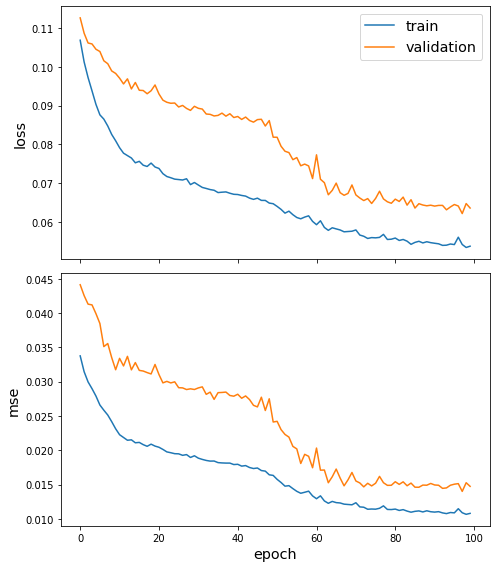

In [41]:
sg.utils.plot_history(history)

## Predictions

In [42]:
# Actual prediction
ythat = model.predict(trainX)
yhat = model.predict(testX)

In [43]:
# We need to rescale the predictions because we applied normalization in the first place
## Rescale values
max_speed = train_data.max()
min_speed = train_data.min()

## actual train and test values
train_rescref = np.array(trainY * max_speed)
test_rescref = np.array(testY * max_speed)

In [44]:
## Rescale model predicted values
train_rescpred = np.array((ythat) * max_speed)
test_rescpred = np.array((yhat) * max_speed)

## Evaluating Performance

In [45]:
# Measuring Performance
## Naive prediction benchmark (using previous observed value)

testnpred = np.array(testX)[
    :, :, -1
]  # picking the last speed of the 10 sequence for each segment in each sample
testnpredc = (testnpred) * max_speed

In [46]:
## Performance measures

seg_mael = []
seg_masel = []
seg_nmael = []

for j in range(testX.shape[-1]):

    seg_mael.append(
        np.mean(np.abs(test_rescref.T[j] - test_rescpred.T[j]))
    )  # Mean Absolute Error for NN
    seg_nmael.append(
        np.mean(np.abs(test_rescref.T[j] - testnpredc.T[j]))
    )  # Mean Absolute Error for naive prediction
    if seg_nmael[-1] != 0:
        seg_masel.append(
            seg_mael[-1] / seg_nmael[-1]
        )  # Ratio of the two: Mean Absolute Scaled Error
    else:
        seg_masel.append(np.NaN)

print("Total (ave) MAE for NN: " + str(np.mean(np.array(seg_mael))))
print("Total (ave) MAE for naive prediction: " + str(np.mean(np.array(seg_nmael))))
print(
    "Total (ave) MASE for per-segment NN/naive MAE: "
    + str(np.nanmean(np.array(seg_masel)))
)
print(
    "...note that MASE<1 (for a given segment) means that the NN prediction is better than the naive prediction."
)

Total (ave) MAE for NN: 4.128168937486537
Total (ave) MAE for naive prediction: 5.619645381284217
Total (ave) MASE for per-segment NN/naive MAE: 0.726780215785159
...note that MASE<1 (for a given segment) means that the NN prediction is better than the naive prediction.


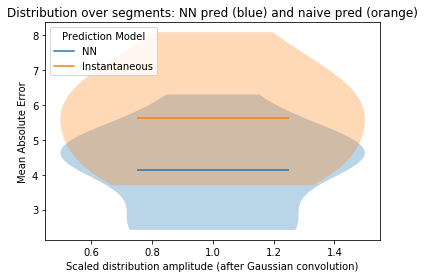

In [47]:
# plot violin plot of MAE for naive and NN predictions
fig, ax = plt.subplots()
# xl = minsl

ax.violinplot(
    list(seg_mael), showmeans=True, showmedians=False, showextrema=False, widths=1.0
)

ax.violinplot(
    list(seg_nmael), showmeans=True, showmedians=False, showextrema=False, widths=1.0
)

line1 = mlines.Line2D([], [], label="NN")
line2 = mlines.Line2D([], [], color="C1", label="Instantaneous")

ax.set_xlabel("Scaled distribution amplitude (after Gaussian convolution)")
ax.set_ylabel("Mean Absolute Error")
ax.set_title("Distribution over segments: NN pred (blue) and naive pred (orange)")
plt.legend(handles=(line1, line2), title="Prediction Model", loc=2)
plt.show()

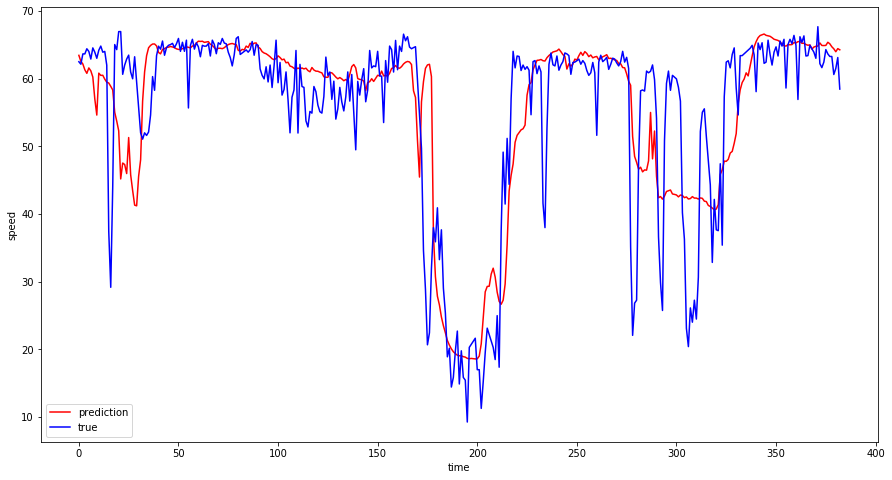

In [48]:
##all test result visualization
fig1 = plt.figure(figsize=(15, 8))
#    ax1 = fig1.add_subplot(1,1,1)
a_pred = test_rescpred[:, 100]
a_true = test_rescref[:, 100]
plt.plot(a_pred, "r-", label="prediction")
plt.plot(a_true, "b-", label="true")
plt.xlabel("time")
plt.ylabel("speed")
plt.legend(loc="best", fontsize=10)
plt.show()